# DSCI 591 Data Analysis
## Covid-19

In [1]:
import os
import glob
import re
import scipy

import pandas as pd
import pyspark.pandas as ps
from pyspark.sql import SparkSession
import findspark

from ipynb.fs.full.covid_data_collection import get_counties_df

In [104]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 100)

### Initialize Spark

In [2]:
findspark.init() 

In [3]:
spark = SparkSession.builder.getOrCreate()

21/10/31 14:09:45 WARN Utils: Your hostname, noah-WS-Z390-PRO resolves to a loopback address: 127.0.1.1; using 10.0.0.58 instead (on interface eno1)
21/10/31 14:09:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/10/31 14:09:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
21/10/31 14:09:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Merge and reformat COVID data by date and FIPS

In [84]:
# FIPS codes from the FCC.  Attempt to match all counties


def make_lookup_functions():
    fcc_county_file = './config/fcc_county_fips.txt'
    with open(fcc_county_file) as fh:
        state = None
        fips_to_county = {}
        county_to_fips = {}
        for row in fh:
            if match := re.match(r'\s+(\d\d\d\d\d)\s+ (.*)', row):
                fips, location = match.groups()
                if fips.endswith('000'):
                    state = location.replace(' ','')
                    continue

                location = location.split(' County')[0]
                location = location.split(' Borough')[0]
                location = location.split(' Census Area')[0]
                location = location.split(' Parish')[0]
                location = location.split(' National Park')[0]
                
                if state == 'Florida' and location == 'Dade':
                    location = 'Miami-Dade'
                if state == 'Massachusetts' and location == 'Dukes':
                    location = 'DukesandNantucket'
                if state == 'Alaska' and location == 'Wrangell-Petersburg':
                    location = 'Wrangell'
                if state == 'Alaska' and location == 'Skagway-Hoonah-Angoon':
                    location = 'Skagway'
                if state == 'Alaska' and location == 'Prince of Wales-Outer Ketchikan':
                    location = 'Prince of Wales'
                if state == 'New York' and location == 'New York':
                    location = 'New York City'
                    
                try:
                    location = ''.join([s[0].upper() + s[1:] for s in location.split(' ')])    
                except:
                    pass  # garbage

                county = location.replace(' ', '') + '_' + state + '_UnitedStates'
                fips_to_county[int(fips)] = county
                county_to_fips[county.lower()] = int(fips)
                
        def lookup_county_from_fips(fips_):
            return fips_to_county[int(fips_)]
        
        def lookup_fips_from_county(county_):
            try:
                return county_to_fips[county_.lower()]
            except KeyError:
                pass
            
            try:
                county_ = county_.lower()
                parts = county_.split('_')
                parts[0] = parts[0][:parts[0].index('city')]
                return county_to_fips['_'.join(parts)]
            except:
                pass
            
            try:
                parts = county_.split('_')
                parts[0] = parts[0] +'city'
                return county_to_fips['_'.join(parts)]
            except:
                pass
    
            parts = county_.split('_')
            for k, v in county_to_fips.items():
                part0, part1, _ = k.split('_')
                if part1 != parts[1]:
                    continue
                if parts[0].startswith(part0) or part0.startswith(parts[0]):
                    return v

            raise KeyError
                
        
        return lookup_county_from_fips, lookup_fips_from_county

get_county_from_fips,  get_fips_from_county = make_lookup_functions()

In [85]:
def merge_processed_data() -> ps.DataFrame:
    path = './processed_data/county_merged_parts/*.pkl'
    sdf = None
    error_count = 0
    total_length = 0
    for file in glob.glob(path):
        county = re.search(r'merged_parts.(.*)\.pkl', file).groups(1)[0]

        df = pd.read_pickle(file)
 
        try:
            df.reset_index(inplace=True)

            df['fips'] = get_fips_from_county(county)
            df['county'] = county
            df['Date Local'] = df.dates.to_list()
            
            if sdf is not None:
                sdf = sdf.append(df, ignore_index=True)
            else:
                sdf = df

        except KeyError:
            if not county.startswith('Unassigned') and not county.startswith('Outof'):
                print(f'Key Error {county}')
        
    return sdf
    
    
# sdf = merge_processed_data()



Key Error KansasCity_Missouri_UnitedStates
Key Error Hoonah-Angoon_Alaska_UnitedStates


In [87]:
def pickle_sdf(sdf):
    sdf.to_pickle('./processed_data/merged_eda/sdf.pkl')
    
def load_sdf():
    return pd.read_pickle('./processed_data/merged_eda/sdf.pkl')

pickle_sdf(sdf)

In [ ]:
# To save time
sdf = load_sdf()

In [88]:
sdf.head()

,dates,JHU_ConfirmedCases.data,JHU_ConfirmedCases.missing,NYT_ConfirmedCases.data,NYT_ConfirmedCases.missing,JHU_ConfirmedDeaths.data,JHU_ConfirmedDeaths.missing,JHU_ConfirmedRecoveries.data,JHU_ConfirmedRecoveries.missing,NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.data,...,AverageWindSpeed.data,AverageWindSpeed.missing,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,fips,LND110210,county,Date Local
0,2020-01-01,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,6.510417,0.0,NaN,NaN,NaN,4148.0,31129,NaN,Nuckolls_Nebraska_UnitedStates,2020-01-01
1,2020-01-02,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,5.322917,0.0,NaN,NaN,NaN,4148.0,31129,NaN,Nuckolls_Nebraska_UnitedStates,2020-01-02
2,2020-01-03,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,8.593750,0.0,NaN,NaN,NaN,4148.0,31129,NaN,Nuckolls_Nebraska_UnitedStates,2020-01-03
3,2020-01-04,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,8.359375,0.0,NaN,NaN,NaN,4148.0,31129,NaN,Nuckolls_Nebraska_UnitedStates,2020-01-04
4,2020-01-05,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,8.020833,0.0,NaN,NaN,NaN,4148.0,31129,NaN,Nuckolls_Nebraska_UnitedStates,2020-01-05


### EDA on Covid Data Set

In [101]:
sdf_filtered.columns

Index(['dates', 'JHU_ConfirmedCases.data', 'JHU_ConfirmedCases.missing',
       'NYT_ConfirmedCases.data', 'NYT_ConfirmedCases.missing',
       'JHU_ConfirmedDeaths.data', 'JHU_ConfirmedDeaths.missing',
       'JHU_ConfirmedRecoveries.data', 'JHU_ConfirmedRecoveries.missing',
       'NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.data',
       'NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.missing',
       'NYT_ConfirmedDeaths.data', 'NYT_ConfirmedDeaths.missing',
       'NYT_AllCausesDeathsWeekly_Excess_Deaths.data',
       'NYT_AllCausesDeathsWeekly_Excess_Deaths.missing',
       'NYT_AllCausesDeathsWeekly_Deaths_AllCauses.data',
       'NYT_AllCausesDeathsWeekly_Deaths_AllCauses.missing',
       'NYT_AllCausesDeathsMonthly_Deaths_AllCauses.data',
       'NYT_AllCausesDeathsMonthly_Deaths_AllCauses.missing',
       'NYT_AllCausesDeathsMonthly_Excess_Deaths.data',
       'NYT_AllCausesDeathsMonthly_Excess_Deaths.missing',
       'NYT_AllCausesDeathsMonthly_Expected_Deaths_A

In [139]:
sdf['jhu_death_rate'] = sdf['JHU_ConfirmedDeaths.data']/sdf['latestTotalPopulation']
sdf['jhu_case_rate'] = sdf['JHU_ConfirmedCases.data']/sdf['latestTotalPopulation']
sdf['density'] = sdf['latestTotalPopulation']/sdf['LND110210']
sdf['latestTotalPopulation_to_hospitalIcuBeds'] = sdf['latestTotalPopulation']/sdf['hospitalIcuBeds']
sdf['cold_day'] = [1 if t < 50 else 0 for t in sdf['AverageDailyTemperature.data']]
sdf['hot_day'] = [1 if t > 90 else 0 for t in sdf['AverageDailyTemperature.data']]

sdf_filtered = sdf[sdf.dates >= '2020-03-11']
sdf_filtered = sdf_filtered[sdf_filtered.dates <= '2021-03-11']

sdf_rollup = sdf_filtered.groupby(by='county').agg({   'jhu_death_rate': 'max',
                                                       'jhu_case_rate': 'max',
                                                       'JHU_ConfirmedDeaths.data': 'max',  
                                                       'NYT_ConfirmedDeaths.data': 'max',
                                                       'MaleAndFemale_AtLeast65_Population.data': 'max',
                                                       'Male_Total_Population.data': 'max',
                                                       'Female_Total_Population.data': 'max',
                                                       'MaleAndFemale_Under18_Population.data': 'max',
                                                       'MaleAndFemale_Under18_Population.data': 'max',
                                                       'BLS_EmployedPopulation.data': 'mean',
                                                       'BLS_UnemployedPopulation.data': 'mean',
                                                       'AverageDailyTemperature.data': 'mean',
                                                       'AverageDewPoint.data': 'mean',
                                                       'AverageRelativeHumidity.data': 'mean',
                                                       'AverageSurfaceAirPressure.data': 'mean',
                                                       'AveragePrecipitationTotal.data': 'mean',
                                                       'AverageWindDirection.data': 'mean',
                                                       'AverageWindSpeed.data': 'mean',
                                                       'cold_day': 'sum',
                                                       'hot_day': 'sum',
                                                       'density': 'max'})
corr = sdf_rollup.corr()
sdf_rollup

,jhu_death_rate,jhu_case_rate,JHU_ConfirmedDeaths.data,NYT_ConfirmedDeaths.data,MaleAndFemale_AtLeast65_Population.data,Male_Total_Population.data,Female_Total_Population.data,MaleAndFemale_Under18_Population.data,BLS_EmployedPopulation.data,BLS_UnemployedPopulation.data,AverageDailyTemperature.data,AverageDewPoint.data,AverageRelativeHumidity.data,AverageSurfaceAirPressure.data,AveragePrecipitationTotal.data,AverageWindDirection.data,AverageWindSpeed.data,cold_day,hot_day,density
county,,,,,,,,,,,,,,,,,,,,
Abbeville_SouthCarolina_UnitedStates,0.001427,0.093163,35.0,35.0,5343.0,11868.0,12673.0,4924.0,9395.829235,711.547814,61.102056,53.165692,78.530959,29.402067,0.003818,119.239908,4.988907,92,0,50.006116
Acadia_Louisiana_UnitedStates,0.002998,0.099283,186.0,186.0,9491.0,30342.0,31848.0,16074.0,21409.566940,1764.116120,68.187813,61.044114,80.666439,30.013856,0.001537,123.753259,6.311746,44,0,94.707840
Accomack_Virginia_UnitedStates,0.001083,0.081570,35.0,35.0,7638.0,15817.0,16595.0,6656.0,14839.637978,1107.521858,58.886118,51.278149,77.986296,30.006036,0.003085,184.455209,9.119532,116,0,71.893215
Ada_Idaho_UnitedStates,0.000916,0.098871,441.0,441.0,67792.0,235266.0,234700.0,111737.0,243629.855191,14593.210383,53.482496,33.065359,52.752040,27.058025,0.001067,174.301078,7.287610,170,0,457.530069
Adair_Iowa_UnitedStates,0.004195,0.129055,30.0,31.0,1603.0,3509.0,3554.0,1528.0,3981.464481,173.717213,50.057733,42.874217,79.960795,28.646217,0.000000,175.671733,10.408441,174,0,12.563458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yuma_Arizona_UnitedStates,0.003761,0.171142,804.0,804.0,39828.0,109306.0,102822.0,53494.0,80597.789617,16296.077869,76.427328,38.856404,30.852376,29.661501,0.000241,162.640691,6.857026,1,95,38.771742
Yuma_Colorado_UnitedStates,0.001697,0.073061,17.0,17.0,1851.0,4989.0,5031.0,2709.0,5442.870219,175.267760,51.212688,33.219917,58.118084,26.502609,0.000000,179.373435,10.292947,172,0,4.237421
Zapata_Texas_UnitedStates,0.002045,0.123351,29.0,29.0,1843.0,7083.0,7107.0,4704.0,3810.424863,634.028689,76.073671,60.406905,63.002490,29.539786,0.000845,125.214808,6.214965,17,45,14.201581


In [140]:
display(corr)

,jhu_death_rate,jhu_case_rate,JHU_ConfirmedDeaths.data,NYT_ConfirmedDeaths.data,MaleAndFemale_AtLeast65_Population.data,Male_Total_Population.data,Female_Total_Population.data,MaleAndFemale_Under18_Population.data,BLS_EmployedPopulation.data,BLS_UnemployedPopulation.data,AverageDailyTemperature.data,AverageDewPoint.data,AverageRelativeHumidity.data,AverageSurfaceAirPressure.data,AveragePrecipitationTotal.data,AverageWindDirection.data,AverageWindSpeed.data,cold_day,hot_day,density
jhu_death_rate,1.000000,0.261642,0.047332,0.010542,-0.021493,-0.021956,-0.020982,-0.021680,-0.010346,-0.001268,0.060937,0.034548,-0.022824,0.010768,-0.019274,-0.015716,0.016739,-0.058890,0.021202,-0.046218
jhu_case_rate,0.261642,1.000000,0.034326,0.043867,-0.028351,-0.017911,-0.017995,-0.012356,0.037298,0.017996,0.067116,0.074134,0.038510,0.032660,-0.017300,0.016496,0.064968,-0.072992,0.030505,-0.033308
JHU_ConfirmedDeaths.data,0.047332,0.034326,1.000000,0.817797,0.720351,0.716927,0.721507,0.705666,0.700243,0.747132,0.083133,0.031634,-0.064277,0.044316,0.030493,0.025600,0.023443,-0.075381,0.113439,0.365571
NYT_ConfirmedDeaths.data,0.010542,0.043867,0.817797,1.000000,0.676799,0.680213,0.680505,0.672297,0.671320,0.687978,0.094919,0.030178,-0.079505,0.034792,0.021040,0.008383,0.004227,-0.090561,0.131320,0.364403
MaleAndFemale_AtLeast65_Population.data,-0.021493,-0.028351,0.720351,0.676799,1.000000,0.982838,0.984425,0.966947,0.974032,0.949891,0.132254,0.060241,-0.078482,0.055870,0.058780,0.027475,-0.000522,-0.127962,0.153598,0.401649
Male_Total_Population.data,-0.021956,-0.017911,0.716927,0.680213,0.982838,1.000000,0.999571,0.994914,0.991786,0.969765,0.121740,0.045908,-0.088454,0.046054,0.047775,0.032678,0.004740,-0.120173,0.150422,0.402393
Female_Total_Population.data,-0.020982,-0.017995,0.721507,0.680505,0.984425,0.999571,1.000000,0.994321,0.991364,0.970415,0.122629,0.048714,-0.085180,0.047547,0.049707,0.032265,0.004995,-0.120606,0.146230,0.407420
MaleAndFemale_Under18_Population.data,-0.021680,-0.012356,0.705666,0.672297,0.966947,0.994914,0.994321,1.000000,0.986531,0.958268,0.125981,0.045002,-0.094858,0.043857,0.043623,0.035528,0.008580,-0.123150,0.160778,0.385969
BLS_EmployedPopulation.data,-0.010346,0.037298,0.700243,0.671320,0.974032,0.991786,0.991364,0.986531,1.000000,0.955217,0.114089,0.038329,-0.087990,0.041166,0.047274,0.036048,0.004599,-0.111958,0.148135,0.421042
BLS_UnemployedPopulation.data,-0.001268,0.017996,0.747132,0.687978,0.949891,0.969765,0.970415,0.958268,0.955217,1.000000,0.095759,0.024871,-0.087940,0.035769,0.036146,0.032110,0.010404,-0.096661,0.131084,0.367251


In [136]:
file = './processed_data/county_merged_parts/Yuma_Arizona_UnitedStates.pkl'
df = pd.read_pickle(file)
df = df[df.index > '2020-06-30']
df[:5] #['JHU_ConfirmedCases.data', 'NYT_ConfirmedCases.data']

,JHU_ConfirmedCases.data,JHU_ConfirmedCases.missing,NYT_ConfirmedCases.data,NYT_ConfirmedCases.missing,JHU_ConfirmedDeaths.data,JHU_ConfirmedDeaths.missing,JHU_ConfirmedRecoveries.data,JHU_ConfirmedRecoveries.missing,NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.data,NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.missing,NYT_ConfirmedDeaths.data,NYT_ConfirmedDeaths.missing,NYT_AllCausesDeathsWeekly_Excess_Deaths.data,NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,NYT_AllCausesDeathsWeekly_Deaths_AllCauses.data,NYT_AllCausesDeathsWeekly_Deaths_AllCauses.missing,NYT_AllCausesDeathsMonthly_Deaths_AllCauses.data,NYT_AllCausesDeathsMonthly_Deaths_AllCauses.missing,NYT_AllCausesDeathsMonthly_Excess_Deaths.data,NYT_AllCausesDeathsMonthly_Excess_Deaths.missing,NYT_AllCausesDeathsMonthly_Expected_Deaths_AllCauses.data,NYT_AllCausesDeathsMonthly_Expected_Deaths_AllCauses.missing,TotalPopulation.data,TotalPopulation.missing,MaleAndFemale_AtLeast65_Population.data,MaleAndFemale_AtLeast65_Population.missing,Male_Total_Population.data,Male_Total_Population.missing,Female_Total_Population.data,Female_Total_Population.missing,MaleAndFemale_Under18_Population.data,MaleAndFemale_Under18_Population.missing,BLS_EmployedPopulation.data,BLS_EmployedPopulation.missing,BLS_UnemployedPopulation.data,BLS_UnemployedPopulation.missing,BLS_UnemploymentRate.data,BLS_UnemploymentRate.missing,BLS_LaborForcePopulation.data,BLS_LaborForcePopulation.missing,AverageDailyTemperature.data,AverageDailyTemperature.missing,AverageDewPoint.data,AverageDewPoint.missing,AverageRelativeHumidity.data,AverageRelativeHumidity.missing,AverageSurfaceAirPressure.data,AverageSurfaceAirPressure.missing,AveragePrecipitationTotal.data,AveragePrecipitationTotal.missing,AveragePrecipitation.data,AveragePrecipitation.missing,AverageWindDirection.data,AverageWindDirection.missing,AverageWindSpeed.data,AverageWindSpeed.missing,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,fips,LND110210
dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-01,6498.0,0,6498.0,0,98.0,0,0.0,100,0.0,100,98.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,213787.0,0,39828.0,0,109306.0,0,102822.0,0,53494.0,0,74898.0,0,24684.0,0,24.787612,0,99582.0,0,89.291667,0,38.291667,0,17.500000,0,29.505000,0,0.0,0,0.0,0,126.250000,0,9.875000,0,42.0,447.0,456.0,213787.0,4027.0,5513.99
2020-07-02,6683.0,0,6683.0,0,103.0,0,0.0,100,0.0,100,103.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,213787.0,0,39828.0,0,109306.0,0,102822.0,0,53494.0,0,74898.0,0,24684.0,0,24.787612,0,99582.0,0,91.625000,0,54.000000,0,30.541667,0,29.545833,0,0.0,0,0.0,0,174.583333,0,11.333333,0,42.0,447.0,456.0,213787.0,4027.0,5513.99
2020-07-03,6838.0,0,6838.0,0,107.0,0,0.0,100,0.0,100,107.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,213787.0,0,39828.0,0,109306.0,0,102822.0,0,53494.0,0,74898.0,0,24684.0,0,24.787612,0,99582.0,0,93.291667,0,58.625000,0,32.958333,0,29.605000,0,0.0,0,0.0,0,132.083333,0,5.666667,0,42.0,447.0,456.0,213787.0,4027.0,5513.99
2020-07-04,7062.0,0,7062.0,0,110.0,0,0.0,100,0.0,100,110.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,213787.0,0,39828.0,0,109306.0,0,102822.0,0,53494.0,0,74898.0,0,24684.0,0,24.787612,0,99582.0,0,95.458333,0,55.125000,0,28.250000,0,29.580000,0,0.0,0,0.0,0,123.333333,0,4.208333,0,42.0,447.0,456.0,213787.0,4027.0,5513.99
2020-07-05,7346.0,0,7346.0,0,114.0,0,0.0,100,0.0,100,114.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,213787.0,0,39828.0,0,109306.0,0,102822.0,0,53494.0,0,74898.0,0,24684.0,0,24.787612,0,99582.0,0,97.250000,0,47.958333,0,22.166667,0,29.524583,0,0.0,0,0.0,0,228.750000,0,6.333333,0,42.0,447.0,456.0,213787.0,4027.0,5513.99


#### Pull in the NO2 data and merge it

In [34]:
def get_no2_df():
    filename = '../air_quality/no2/daily_2020_multi_index.pkl'
    daily_no2 = pd.read_pickle(filename).reset_index()
    daily_no2 = daily_no2.astype({'fips': 'int32'})
    return daily_no2

daily_no2 = get_no2_df()
daily_no2.head()

,Date Local,fips,Arithmetic Mean,1st Max Value,AQI
0,2020-01-01,1073,16.373918,31.0,29
1,2020-01-01,4013,16.660833,34.0,32
2,2020-01-01,4019,11.206250,23.7,22
3,2020-01-01,5035,9.175000,23.1,22
4,2020-01-01,5119,12.637500,28.9,26


In [45]:
def merge_sdf_no2(sdf, daily_no2):
    return sdf.merge(daily_no2, left_on=['fips', 'Date Local'], right_on=['fips', 'Date Local'], suffixes=(None, '_r'))

def pickle_sdf_no2(sdf_no2):
    sdf_no2.to_pickle('./processed_data/merged_eda/sdf_no2.pkl')
    
def load_sdf_no2():
    return pd.read_pickle('./processed_data/merged_eda/sdf_no2.pkl')

sdf_no2 = merge_sdf_no2(sdf, daily_no2)
pickle_sdf_no2(sdf_no2)

In [46]:
sdf_no2.head()

,dates,JHU_ConfirmedCases.data,JHU_ConfirmedCases.missing,NYT_ConfirmedCases.data,NYT_ConfirmedCases.missing,JHU_ConfirmedDeaths.data,JHU_ConfirmedDeaths.missing,JHU_ConfirmedRecoveries.data,JHU_ConfirmedRecoveries.missing,NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.data,...,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,fips,LND110210,county,Date Local,Arithmetic Mean,1st Max Value,AQI
0,2020-01-01,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-01,4.130435,14.0,13
1,2020-01-02,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-02,10.739130,20.0,19
2,2020-01-03,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-03,17.130435,24.0,23
3,2020-01-04,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-04,6.826087,15.0,14
4,2020-01-05,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-05,2.260870,5.0,5


In [48]:
sdf = load_sdf_no2()

#### Average $NO_2$ to Covid Deaths

In [49]:
sdf.head()

,dates,JHU_ConfirmedCases.data,JHU_ConfirmedCases.missing,NYT_ConfirmedCases.data,NYT_ConfirmedCases.missing,JHU_ConfirmedDeaths.data,JHU_ConfirmedDeaths.missing,JHU_ConfirmedRecoveries.data,JHU_ConfirmedRecoveries.missing,NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.data,...,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,fips,LND110210,county,Date Local,Arithmetic Mean,1st Max Value,AQI
0,2020-01-01,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-01,4.130435,14.0,13
1,2020-01-02,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-02,10.739130,20.0,19
2,2020-01-03,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-03,17.130435,24.0,23
3,2020-01-04,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-04,6.826087,15.0,14
4,2020-01-05,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-05,2.260870,5.0,5


In [76]:
sdf['density'] = sdf['latestTotalPopulation']/sdf['LND110210']

deaths_to_no2 = sdf.groupby(by='county').agg({'JHU_ConfirmedDeaths.data': 'max', 'Arithmetic Mean': 'mean', 'density': 'max'})

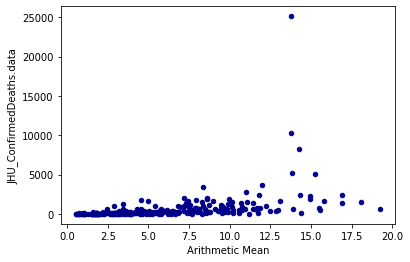

In [65]:
 ax1 = deaths_to_no2.plot.scatter(y='JHU_ConfirmedDeaths.data',
                       x='Arithmetic Mean',
                       c='DarkBlue')

In [66]:
deaths_to_no2[deaths_to_no2['JHU_ConfirmedDeaths.data'] > 20000]

,JHU_ConfirmedDeaths.data,Arithmetic Mean,LND110210
county,,,
Queens_NewYork_UnitedStates,25124.0,13.742246,NaN


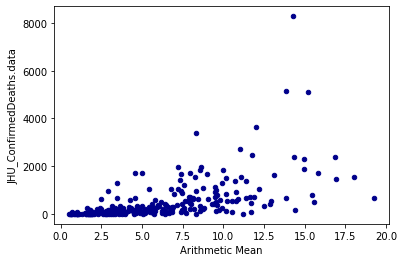

In [63]:
 
ax1 = deaths_to_no2[deaths_to_no2['JHU_ConfirmedDeaths.data'] < 10000].plot.scatter(y='JHU_ConfirmedDeaths.data',
                       x='Arithmetic Mean',
                       c='DarkBlue')

#### Average Density to Deaths

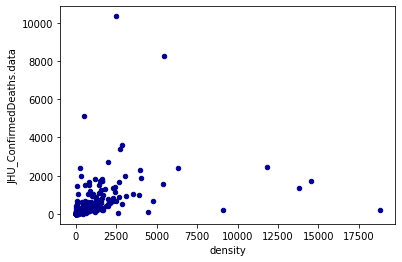

In [77]:
ax1 = deaths_to_no2.plot.scatter(y='JHU_ConfirmedDeaths.data',
                       x='density',
                       c='DarkBlue')

In [78]:
deaths_to_no2[deaths_to_no2['density'] > 17500]

,JHU_ConfirmedDeaths.data,Arithmetic Mean,density
county,,,
SanFrancisco_California_UnitedStates,186.0,8.724803,18808.384894


In [80]:
deaths_to_no2.sort_values(by='density', ascending=False)

,JHU_ConfirmedDeaths.data,Arithmetic Mean,density
county,,,
SanFrancisco_California_UnitedStates,186.0,8.724803,18808.384894
Hudson_NewJersey_UnitedStates,1699.0,15.813313,14557.068630
Suffolk_Massachusetts_UnitedStates,1374.0,10.706350,13824.711952
Philadelphia_Pennsylvania_UnitedStates,2450.0,11.788048,11812.557793
Arlington_Virginia_UnitedStates,181.0,7.452275,9119.830574
...,...,...,...
St.Joseph_Indiana_UnitedStates,347.0,4.708785,NaN
St.LouisCity_Missouri_UnitedStates,109.0,9.540296,NaN
St.Louis_Minnesota_UnitedStates,205.0,4.855522,NaN


In [82]:
sdf[sdf.county == 'SanFrancisco_California_UnitedStates']

,dates,JHU_ConfirmedCases.data,JHU_ConfirmedCases.missing,NYT_ConfirmedCases.data,NYT_ConfirmedCases.missing,JHU_ConfirmedDeaths.data,JHU_ConfirmedDeaths.missing,JHU_ConfirmedRecoveries.data,JHU_ConfirmedRecoveries.missing,NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.data,...,hospitalLicensedBeds,latestTotalPopulation,fips,LND110210,county,Date Local,Arithmetic Mean,1st Max Value,AQI,density
54226,2020-01-01,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,2860.0,881549.0,6075,46.87,SanFrancisco_California_UnitedStates,2020-01-01,10.273913,23.6,22,18808.384894
54227,2020-01-02,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,2860.0,881549.0,6075,46.87,SanFrancisco_California_UnitedStates,2020-01-02,23.531818,35.5,33,18808.384894
54228,2020-01-03,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,2860.0,881549.0,6075,46.87,SanFrancisco_California_UnitedStates,2020-01-03,23.317391,36.6,34,18808.384894
54229,2020-01-04,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,2860.0,881549.0,6075,46.87,SanFrancisco_California_UnitedStates,2020-01-04,12.230435,24.6,23,18808.384894
54230,2020-01-05,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,2860.0,881549.0,6075,46.87,SanFrancisco_California_UnitedStates,2020-01-05,10.656522,23.3,22,18808.384894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54587,2020-12-27,22319.0,0,22322.0,0,182.0,0,0.0,100,0.0,...,2860.0,881549.0,6075,46.87,SanFrancisco_California_UnitedStates,2020-12-27,12.717391,20.4,19,18808.384894
54588,2020-12-28,22514.0,0,22517.0,0,182.0,0,0.0,100,0.0,...,2860.0,881549.0,6075,46.87,SanFrancisco_California_UnitedStates,2020-12-28,10.404348,25.5,24,18808.384894
54589,2020-12-29,22726.0,0,22729.0,0,182.0,0,0.0,100,0.0,...,2860.0,881549.0,6075,46.87,SanFrancisco_California_UnitedStates,2020-12-29,19.439130,26.1,25,18808.384894
54590,2020-12-30,22996.0,0,22999.0,0,184.0,0,0.0,100,0.0,...,2860.0,881549.0,6075,46.87,SanFrancisco_California_UnitedStates,2020-12-30,12.160870,25.3,24,18808.384894
